# Adaptive Construction of Polynomial Chaos Expansions

## Polynomial Chaos Background
$$
f(\theta) \approx \sum_{\mathbf{k}\in \mathcal{K}} c_\mathbf{k} \Phi_{\mathbf{k}}(\theta)
$$


## Imports

In [1]:
%matplotlib inline

import pymuqModeling as mm
import pymuqUtilities as mu
import pymuqApproximation as ma
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import matplotlib.pyplot as plt

## Define the model
To construct a polynomial chaos expansion with MUQ, we need to first define the model as a child of the `ModPiece` class.   Here, we use a built in `ModPiece` called `CosOperator` that simply returns a componentwise cosine of the input.

In [2]:
dim = 2
model = mm.CosOperator(dim)

## Define the PCE factory

In [3]:
quad1d = ma.GaussPattersonQuadrature()
polys1d = ma.Legendre()
smolyPCE = ma.AdaptiveSmolyakPCE(model, [quad1d]*dim, [polys1d]*dim);

## Construct the PCE

In [4]:
# Start with a linear approximation
initialOrder = 1
multis = mu.MultiIndexFactory.CreateTotalOrder(dim,initialOrder)

options = dict()
options['ShouldAdapt']  = 1    # After constructing an initial approximation with the terms in "multis", should we continue to adapt?
options['ErrorTol']     = 5e-4 # Stop when the estimated L2 error is below this value
options['MaximumEvals'] = 50   # Stop adapting when more than this many model evaluations has occured

In [5]:
pce = smolyPCE.Compute(multis, options);

In [6]:
print('Number of Model Evaluations:')
print(smolyPCE.NumEvals())

print('\nEstimated L2 Error:')
print('%0.4e'%smolyPCE.Error())

Number of Model Evaluations:
49

Estimated L2 Error:
1.0322e-04


## Plot the results

Before plotting, we need to evaluate the true model and the PCE surrogate at a grid of points.  These evaluations are completed in the following cell.

In [7]:
numPlot = 50

x = np.linspace(-1,1,numPlot)
X, Y = np.meshgrid(x,x)

trueEvals = np.zeros(X.shape)
pceEvals = np.zeros(X.shape)

for i in range(numPlot):
    for j in range(numPlot):
        pt = [X[i,j],Y[i,j]]
        
        trueEvals[i,j] = model.Evaluate([pt])[0][0]
        pceEvals[i,j] = pce.Evaluate([pt])[0][0]        

The cell below plots the true model evaluations, the PCE evaluations, and the error.  

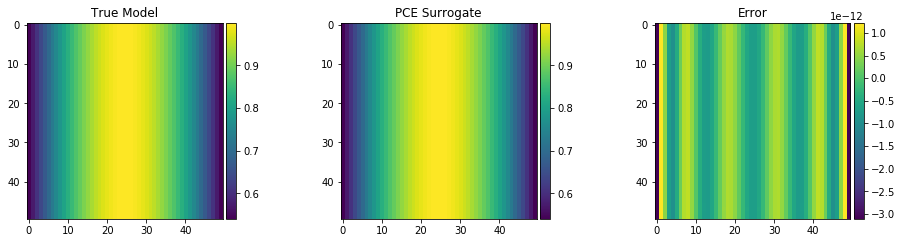

In [8]:
fig, axs = plt.subplots(ncols=3, figsize=(15,7), gridspec_kw={'wspace':0.5})

# Plot the true model
im = axs[0].imshow(trueEvals)
axs[0].set_title('True Model')

divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

# Plot the PCE Surrogate
im = axs[1].imshow(pceEvals)
axs[1].set_title('PCE Surrogate')

divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


im = axs[2].imshow(pceEvals-trueEvals)

axs[2].set_title('Error')
divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

plt.show()

## Propagate Uncertainty

In [9]:
print('Prediction Mean:')
print(pce.Mean())

print('\nPrediction Variance:')
print(pce.Variance())

print('\nPrediction Covariance:')
print(pce.Covariance())


Prediction Mean:
[0.84147098 0.84147098]

Prediction Variance:
[0.01925094 0.01925094]

Prediction Covariance:
[[ 1.92509384e-02 -2.23155898e-17]
 [-2.23155898e-17  1.92509384e-02]]


## Sensitivity analysis

In [10]:
totalSens1 = pce.TotalSensitivity(0)
totalSens2 = pce.TotalSensitivity(1)

print('Total Sensitivities:')
print('  Output 0 wrt parameter 0 = %0.2e'%totalSens1[0])
print('  Output 0 wrt parameter 1 = %0.2e'%totalSens1[1])
print('  Output 1 wrt parameter 0 = %0.2e'%totalSens2[0])
print('  Output 1 wrt parameter 1 = %0.2e'%totalSens2[1])

print('\nAll Total Sensitivities:')
print(pce.TotalSensitivity())

mainEffects1 = pce.SobolSensitivity(0)
mainEffects2 = pce.SobolSensitivity(1)
print('\nFirst Order Sobol Indices:')
print('  Output 0 wrt parameter 0 = %0.2e'%mainEffects1[0])
print('  Output 0 wrt parameter 1 = %0.2e'%mainEffects1[1])
print('  Output 1 wrt parameter 0 = %0.2e'%mainEffects2[0])
print('  Output 1 wrt parameter 1 = %0.2e'%mainEffects2[1])

Total Sensitivities:
  Output 0 wrt parameter 0 = 1.00e+00
  Output 0 wrt parameter 1 = 1.51e-29
  Output 1 wrt parameter 0 = 1.49e-29
  Output 1 wrt parameter 1 = 1.00e+00

All Total Sensitivities:
[[1.00000000e+00 1.48914648e-29]
 [1.50854357e-29 1.00000000e+00]]

First Order Sobol Indices:
  Output 0 wrt parameter 0 = 1.00e+00
  Output 0 wrt parameter 1 = 1.43e-29
  Output 1 wrt parameter 0 = 1.44e-29
  Output 1 wrt parameter 1 = 1.00e+00
